# Experiment 3: Model Selection

## Installing and importing packages

In [1]:
%pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.2/258.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.5 MB/s eta 0:00:00


In [3]:
import mlflow
import optuna

import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from data_cleaning_utils import clean_data

set_config(transform_output="pandas")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Connecting with dagshub and MLFlow

In [4]:
import dagshub
dagshub.init(repo_owner='SushrutGaikwad', repo_name='swiggy-delivery-time-prediction', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=baa80bf1-f434-46bb-adbd-fca666ca9fe8&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=59a3822e0e64a66b3524f8143fb0abc7c851f1a53d5c6373f989f363cd5d3b1c




Accessing as SushrutGaikwad

Initialized MLflow to track repo "SushrutGaikwad/swiggy-delivery-time-prediction"

Repository SushrutGaikwad/swiggy-delivery-time-prediction initialized!

In [5]:
mlflow.set_tracking_uri("https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow")
mlflow.set_experiment("Exp 3: Model selection")

2025/01/12 16:01:52 INFO mlflow.tracking.fluent: Experiment with name 'Exp 3: Model selection' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/d42b279222c4483e9ac82a58b733baf8', creation_time=1736697712209, experiment_id='7', last_update_time=1736697712209, lifecycle_stage='active', name='Exp 3: Model selection', tags={}>

## Loading and cleaning the data

In [6]:
df = pd.read_csv("/content/swiggy.csv")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [7]:
df = clean_data(df=df)
df.head()

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,distance,distance_type,order_day,order_month,order_day_of_week,order_day_is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,3.025149,short,19,3,saturday,1,15.0,11.0,morning
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,20.183530,very_long,25,3,friday,0,5.0,19.0,evening
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,1.552758,short,19,3,saturday,1,15.0,8.0,morning
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,7.790401,medium,5,4,tuesday,0,10.0,18.0,evening
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,6.210138,medium,26,3,saturday,1,15.0,13.0,afternoon


## Dropping unnecessary columns

In [8]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'distance', 'distance_type',
       'order_day', 'order_month', 'order_day_of_week', 'order_day_is_weekend',
       'pickup_time_minutes', 'order_time_hour', 'order_time_of_day'],
      dtype='object')

In [9]:
cols_to_drop = [
    'rider_id',
    'restaurant_latitude',
    'restaurant_longitude',
    'delivery_latitude',
    'delivery_longitude',
    'order_date',
    'order_time_hour',
    'order_day',
    'city_name',
    'order_day_of_week',
    'order_month',
]

df.drop(columns=cols_to_drop, inplace=True)
df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,6.210138,medium,1,15.0,afternoon


In [10]:
df.shape

(45502, 16)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45502 entries, 0 to 45592
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   43648 non-null  float64 
 1   ratings               43594 non-null  float64 
 2   weather               44977 non-null  object  
 3   traffic               44992 non-null  object  
 4   vehicle_condition     45502 non-null  int64   
 5   type_of_order         45502 non-null  object  
 6   type_of_vehicle       45502 non-null  object  
 7   multiple_deliveries   44509 non-null  float64 
 8   festival              45274 non-null  object  
 9   city_type             44304 non-null  object  
 10  time_taken            45502 non-null  int64   
 11  distance              41872 non-null  float64 
 12  distance_type         41872 non-null  category
 13  order_day_is_weekend  45502 non-null  int64   
 14  pickup_time_minutes   43862 non-null  float64 
 15  order_t

## Checking for duplicates

In [12]:
df.duplicated().sum()

0

## Missing values

In [13]:
df.isna().sum()

,0
age,1854
ratings,1908
weather,525
traffic,510
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,993
festival,228
city_type,1198


In [14]:
df.isna().sum().sum()

17756

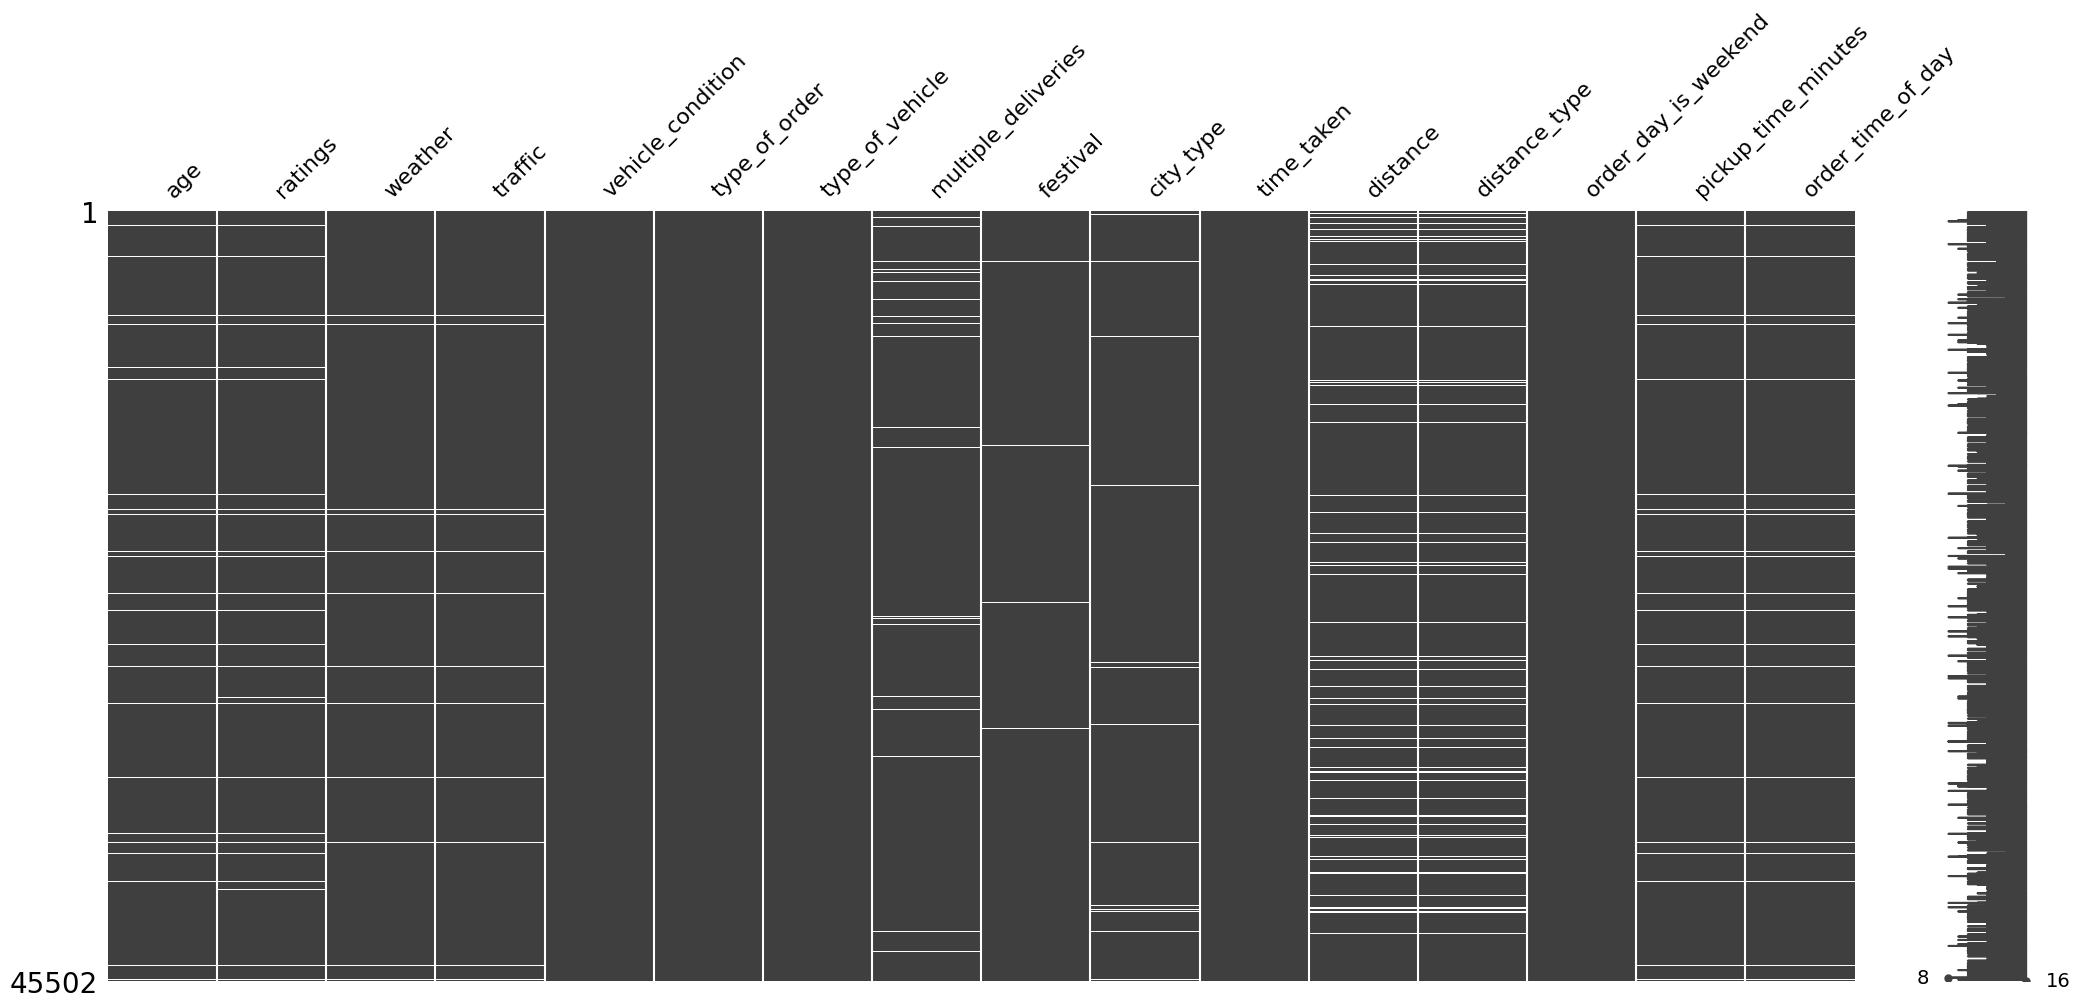

In [15]:
msno.matrix(df);

In [16]:
missing_cols = df.columns[df.isnull().any()]
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'distance', 'distance_type',
       'pickup_time_minutes', 'order_time_of_day'],
      dtype='object')

## Dropping missing values

In [17]:
temp_df = df.copy().dropna()
temp_df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,6.210138,medium,1,15.0,afternoon


## Input-output split

In [18]:
X = temp_df.drop(columns=['time_taken'])
y = temp_df['time_taken']

In [19]:
X.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,6.210138,medium,1,15.0,afternoon


In [20]:
y.head()

,time_taken
0,24
1,33
2,26
3,21
4,30


## Train-test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")

X_train.shape = (30451, 15)
X_test.shape = (7613, 15)


In [23]:
X_train.isna().sum().sum()

0

## Types of columns

In [24]:
X_train.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'distance', 'distance_type', 'order_day_is_weekend',
       'pickup_time_minutes', 'order_time_of_day'],
      dtype='object')

In [25]:
num_cols = ['age', 'ratings', 'pickup_time_minutes', 'distance']

nominal_cat_cols = [
    'weather',
    'type_of_order',
    'type_of_vehicle',
    'festival',
    'city_type',
    'order_day_is_weekend',
    'order_time_of_day',
]

ordinal_cat_cols = ['traffic', 'distance_type']

We did not consider the columns `multiple_deliveries` and `vehicle_condition` as these both are already encoded appropriately.

In [26]:
len(X_train.columns)

15

In [27]:
len(num_cols + nominal_cat_cols + ordinal_cat_cols)

13

In [28]:
for col in ordinal_cat_cols:
    print(f"{col}: {X_train[col].unique()}")

traffic: ['jam' 'low' 'medium' 'high']
distance_type: ['short', 'very_long', 'long', 'medium']
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


## Creating order for ordinal categorical columns

In [29]:
traffic_order = ['low', 'medium', 'high', 'jam']
distance_type_order = ['short', 'medium', 'long', 'very_long']

## Building a preprocessor

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", MinMaxScaler(), num_cols),
        ("nominal_encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_cat_cols),
        ("ordinal_encoder", OrdinalEncoder(categories=[traffic_order, distance_type_order]), ordinal_cat_cols)
    ],
    remainder="passthrough",
    n_jobs=-1,
    force_int_remainder_cols=False,
    verbose_feature_names_out=False,
)

preprocessor.set_output(transform='pandas')

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scaler', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type',
                                  'order_day_is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encoder',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']]),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

## Transforming the input

In [31]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [32]:
X_train_transformed.head()

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_urban,order_day_is_weekend_1,order_time_of_day_afternoon,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
24986,0.052632,0.80,0.5,0.163629,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1,0.0
9452,0.526316,0.96,1.0,0.157036,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,2,1.0
18442,0.631579,1.00,0.0,0.160160,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,2,2.0
15294,0.789474,0.96,0.5,0.003145,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0.0
44012,0.157895,0.88,0.5,0.084651,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0


## Transforming the target

In [33]:
pt = PowerTransformer(method='yeo-johnson')

y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1))

In [34]:
y_train_transformed.head()

,x0
0,-1.058728
1,0.051344
2,1.271713
3,-1.058728
4,-1.058728


## Hyperparameter tuning using optuna

In [35]:
def objective(trial):
    with mlflow.start_run(nested=True):
        model_name = trial.suggest_categorical("model", ["SVM", "RF", "KNN", "GB", "XGB", "LGBM"])

        if model_name == "SVM":
            kernel_svm = trial.suggest_categorical("kernel_svm", ["linear", "poly", "rbf"])

            if kernel_svm == "linear":
                c_linear = trial.suggest_float("c_linear", 0, 10)
                model = SVR(C=c_linear, kernel="linear")
            elif kernel_svm == "poly":
                c_poly = trial.suggest_float("c_poly", 0, 10)
                degree_poly = trial.suggest_int("degree_poly", 1, 5)
                model = SVR(C=c_poly, degree=degree_poly, kernel="poly")
            else:
                c_rbf = trial.suggest_float("c_rbf", 0, 100)
                gamma_rbf = trial.suggest_float("gamma_rbf", 0, 10)
                model = SVR(C=c_rbf, gamma=gamma_rbf, kernel="rbf")

        elif model_name == "RF":
            n_estimators_rf = trial.suggest_int("n_estimators_rf", 10, 200)
            max_depth_rf = trial.suggest_int("max_depth_rf", 2, 20)
            model = RandomForestRegressor(
                n_estimators=n_estimators_rf,
                max_depth=max_depth_rf,
                random_state=42,
                n_jobs=-1,
            )

        elif model_name == "GB":
            n_estimators_gb = trial.suggest_int("n_estimators_gb", 10, 200)
            learning_rate_gb = trial.suggest_float("learning_rate_gb", 0, 1)
            max_depth_gb = trial.suggest_int("max_depth_gb", 2, 20)
            model = GradientBoostingRegressor(
                n_estimators=n_estimators_gb,
                learning_rate=learning_rate_gb,
                max_depth=max_depth_gb,
                random_state=42,
            )

        elif model_name == "KNN":
            n_neighbors_knn = trial.suggest_int("n_neighbors_knn", 1, 25)
            weights_knn = trial.suggest_categorical("weights_knn", ["uniform", "distance"])
            model = KNeighborsRegressor(n_neighbors=n_neighbors_knn, weights=weights_knn, n_jobs=-1)

        elif model_name == "XGB":
            n_estimators_xgb = trial.suggest_int("n_estimators_xgb", 10, 200)
            learning_rate_xgb = trial.suggest_float("learning_rate_xgb", 0.1, 0.5)
            max_depth_xgb = trial.suggest_int("max_depth_xgb", 2, 20)
            model = XGBRegressor(
                n_estimators=n_estimators_xgb,
                learning_rate=learning_rate_xgb,
                max_depth=max_depth_xgb,
                random_state=42,
                n_jobs=-1,
            )

        elif model_name == "LGBM":
            n_estimators_lgbm = trial.suggest_int("n_estimators_lgbm", 10, 200)
            learning_rate_lgbm = trial.suggest_float("learning_rate_lgbm", 0.1, 0.5)
            max_depth_lgbm = trial.suggest_int("max_depth_lgbm", 2, 20)
            model = LGBMRegressor(
                n_estimators=n_estimators_lgbm,
                learning_rate=learning_rate_lgbm,
                max_depth=max_depth_lgbm,
                random_state=42,
            )

        # train the model
        model.fit(X_train_transformed, y_train_transformed.values.ravel())

        # log the model params
        mlflow.log_params(model.get_params())

        # predictions
        y_pred_train = model.predict(X_train_transformed)
        y_pred_test = model.predict(X_test_transformed)

        y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1, 1))
        y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1))

        # error
        error = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)

        # log model name
        mlflow.log_param("model", model_name)

        # log error
        mlflow.log_metric("MAE", error)

        return error

In [36]:
study = optuna.create_study(direction="minimize", study_name="model_selection")

with mlflow.start_run(run_name="Best model") as parent:
    # optimize the objective function
    study.optimize(objective, n_trials=30, n_jobs=-1)

    # log the best params
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score", study.best_value)

[I 2025-01-12 16:03:50,043] A new study created in memory with name: model_selection
[I 2025-01-12 16:03:54,928] Trial 0 finished with value: 3.0980183488712463 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 66, 'learning_rate_lgbm': 0.41436107521157417, 'max_depth_lgbm': 16}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run omniscient-elk-352 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/9c0aa82fec7343908f0d6a25dd45cb09
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:04:14,289] Trial 2 finished with value: 3.3768835067749023 and parameters: {'model': 'XGB', 'n_estimators_xgb': 135, 'learning_rate_xgb': 0.4745136670806763, 'max_depth_xgb': 13}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run redolent-stag-844 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/82c5872b0f5943158a954a5020910093
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7
🏃 View run nebulous-wolf-185 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/f898f3750cc14767a7c23d89e6ec7fd9
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:04:14,486] Trial 1 finished with value: 4.29495468358989 and parameters: {'model': 'KNN', 'n_neighbors_knn': 18, 'weights_knn': 'distance'}. Best is trial 0 with value: 3.0980183488712463.
[I 2025-01-12 16:04:17,960] Trial 3 finished with value: 3.1677842257046707 and parameters: {'model': 'RF', 'n_estimators_rf': 10, 'max_depth_rf': 17}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run mercurial-finch-664 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/1bb1bf24e1e04de4a469439e0e27abd7
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:04:31,601] Trial 4 finished with value: 3.119001517552551 and parameters: {'model': 'RF', 'n_estimators_rf': 62, 'max_depth_rf': 20}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run dashing-gnat-870 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/a99cc6d41020414799f657c7ccf4f1fc
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:16:15,213] Trial 6 finished with value: 4.72596310967875 and parameters: {'model': 'SVM', 'kernel_svm': 'linear', 'c_linear': 5.307395428916638}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run peaceful-shad-351 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/c5f93d9478af4e3eb67bd661ee7a0335
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:16:32,127] Trial 7 finished with value: 4.835136232811098 and parameters: {'model': 'KNN', 'n_neighbors_knn': 2, 'weights_knn': 'distance'}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run unequaled-snipe-997 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/069a194dc4cc497f840effee913c060b
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:16:49,294] Trial 8 finished with value: 4.351384190842524 and parameters: {'model': 'KNN', 'n_neighbors_knn': 10, 'weights_knn': 'uniform'}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run vaunted-frog-865 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/b47eba7c4c1246d989e55ed918995df3
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:17:13,012] Trial 9 finished with value: 3.2902562618255615 and parameters: {'model': 'XGB', 'n_estimators_xgb': 127, 'learning_rate_xgb': 0.1286067341982125, 'max_depth_xgb': 17}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run wise-bat-694 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/9852b1ca9af04b5986a63d472e299c3a
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:17:29,944] Trial 10 finished with value: 4.376553567517257 and parameters: {'model': 'KNN', 'n_neighbors_knn': 6, 'weights_knn': 'distance'}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run rare-tern-961 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/b8084fd93d0c4a5c857a254341be22be
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:17:31,520] Trial 11 finished with value: 3.1442588174730326 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 60, 'learning_rate_lgbm': 0.43927668906191286, 'max_depth_lgbm': 17}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run flawless-goat-466 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/f92eba3b23794a448115853de58d25b8
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:17:49,339] Trial 12 finished with value: 4.026660536043277 and parameters: {'model': 'GB', 'n_estimators_gb': 141, 'learning_rate_gb': 0.9119104711528295, 'max_depth_gb': 19}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run mercurial-lark-230 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/6bffe10aba844fe0a431ad6bc256ac9a
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:17:51,375] Trial 13 finished with value: 3.1107920242613316 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 145, 'learning_rate_lgbm': 0.2660955748929598, 'max_depth_lgbm': 7}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run shivering-conch-173 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/bba2521d1f0a47af8c2542596f304fad
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:17:54,473] Trial 14 finished with value: 3.11350138133649 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 160, 'learning_rate_lgbm': 0.23888705299760624, 'max_depth_lgbm': 6}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run dapper-bass-698 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/5c2bba01e5784e849c0531bdd22244cd
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


🏃 View run youthful-shrimp-120 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/9553c2bdd40d44869fdc814172532d94
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:18:01,411] Trial 15 finished with value: 3.1209556271675174 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 118, 'learning_rate_lgbm': 0.37658497387168033, 'max_depth_lgbm': 13}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run righteous-swan-321 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/fb356fe7ec6b4e6bbea90ede191f6bfd
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:18:07,413] Trial 16 finished with value: 4.311874912997442 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 11, 'learning_rate_lgbm': 0.10654064896922327, 'max_depth_lgbm': 6}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run unequaled-vole-24 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/12d821c9a9e6477880b430fa55cd8432
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:18:13,384] Trial 17 finished with value: 3.1123628216446906 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 190, 'learning_rate_lgbm': 0.27748775409754833, 'max_depth_lgbm': 20}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run blushing-smelt-105 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/fd45e0fde5624131a028d19dc629a5a8
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:18:19,397] Trial 18 finished with value: 6.240281590124105 and parameters: {'model': 'GB', 'n_estimators_gb': 16, 'learning_rate_gb': 0.04545322116584405, 'max_depth_gb': 2}. Best is trial 0 with value: 3.0980183488712463.
[I 2025-01-12 16:20:24,705] Trial 5 finished with value: 5.817000605638997 and parameters: {'model': 'SVM', 'kernel_svm': 'rbf', 'c_rbf': 93.11454405296259, 'gamma_rbf': 2.491652198671183}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run honorable-mare-753 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/dcb7142dc88b4e74b337d26025670994
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:20:26,567] Trial 20 finished with value: 3.1647657370411504 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 93, 'learning_rate_lgbm': 0.4845181748552199, 'max_depth_lgbm': 11}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run stately-mule-381 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/9e0a08c85f6e4261a1a0f94541e0d90e
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7
🏃 View run suave-conch-522 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/c3a2bb6219b14d6896e51e0aa5d84fb8
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:20:29,252] Trial 21 finished with value: 3.1212084481745364 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 124, 'learning_rate_lgbm': 0.357559974312585, 'max_depth_lgbm': 11}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run fortunate-mule-935 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/96e4da6e4d754eb8908c8af68355450d
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:20:35,258] Trial 22 finished with value: 3.1169998944019675 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 200, 'learning_rate_lgbm': 0.2616619179184351, 'max_depth_lgbm': 20}. Best is trial 0 with value: 3.0980183488712463.


🏃 View run melodic-stork-274 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/e5908d9eeea44328b440ab65a6abaacb
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:20:41,253] Trial 23 finished with value: 3.080423953816441 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 190, 'learning_rate_lgbm': 0.2098190678908361, 'max_depth_lgbm': 20}. Best is trial 23 with value: 3.080423953816441.


🏃 View run resilient-skunk-404 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/2f827df534fc4d279fa8486a4600ea62
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:20:47,242] Trial 24 finished with value: 3.704168478214156 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 149, 'learning_rate_lgbm': 0.17662371983040137, 'max_depth_lgbm': 2}. Best is trial 23 with value: 3.080423953816441.


🏃 View run resilient-snake-569 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/0d34f05631a9437b9e2463e336ce9a2e
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:20:53,270] Trial 25 finished with value: 3.080264660734453 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 56, 'learning_rate_lgbm': 0.19910910658486675, 'max_depth_lgbm': 16}. Best is trial 25 with value: 3.080264660734453.


🏃 View run honorable-horse-644 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/0e4d5b39cc624810a519bad4c583e181
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:20:59,253] Trial 26 finished with value: 3.091166938580266 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 60, 'learning_rate_lgbm': 0.1820855974980879, 'max_depth_lgbm': 16}. Best is trial 25 with value: 3.080264660734453.


🏃 View run mercurial-newt-540 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/50093e022c4646ceb337c3798ffd82bc
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:21:41,782] Trial 27 finished with value: 3.2840589766170836 and parameters: {'model': 'GB', 'n_estimators_gb': 198, 'learning_rate_gb': 0.3261509095200358, 'max_depth_gb': 8}. Best is trial 25 with value: 3.080264660734453.
[I 2025-01-12 16:21:43,081] Trial 28 finished with value: 4.113084316253662 and parameters: {'model': 'XGB', 'n_estimators_xgb': 18, 'learning_rate_xgb': 0.31267797676426395, 'max_depth_xgb': 2}. Best is trial 25 with value: 3.080264660734453.


🏃 View run monumental-conch-238 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/e48057eee6ce47aa852f2b11299044c8
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:28:40,093] Trial 19 finished with value: 3.8011984395899927 and parameters: {'model': 'SVM', 'kernel_svm': 'poly', 'c_poly': 4.277695315525593, 'degree_poly': 3}. Best is trial 25 with value: 3.080264660734453.


🏃 View run marvelous-zebra-210 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/8b5a30e88c7541cbae1120fcba10c39b
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


[I 2025-01-12 16:31:21,781] Trial 29 finished with value: 3.797101744866884 and parameters: {'model': 'SVM', 'kernel_svm': 'poly', 'c_poly': 4.886166054967833, 'degree_poly': 3}. Best is trial 25 with value: 3.080264660734453.


🏃 View run angry-turtle-454 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/3d61a14bd6404936b740874a3092d643
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7
🏃 View run Best model at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/771d7b8abcfd4406bbc02aa903cffdaa
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/7


## Best model

In [37]:
# best score

study.best_value

3.080264660734453

In [38]:
study.best_params

{'model': 'LGBM',
 'n_estimators_lgbm': 56,
 'learning_rate_lgbm': 0.19910910658486675,
 'max_depth_lgbm': 16}

In [39]:
lgbm_params = {
    "n_estimators": 56,
    "learning_rate": 0.19910910658486675,
    "max_depth": 16,
}

In [40]:
lgbm = LGBMRegressor(**lgbm_params, random_state=42)

lgbm.fit(X_train_transformed, y_train_transformed.values.ravel())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(learning_rate=0.19910910658486675, max_depth=16, n_estimators=56,
              random_state=42)

In [41]:
y_pred_train = lgbm.predict(X_train_transformed)
y_pred_test = lgbm.predict(X_test_transformed)

y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1))

In [42]:
print(f"The train MAE is {mean_absolute_error(y_train, y_pred_train):.2f} minutes")
print(f"The test MAE is {mean_absolute_error(y_test, y_pred_test):.2f} minutes")

The train MAE is 2.95 minutes
The test MAE is 3.08 minutes


In [43]:
print(f"The train R2 is {r2_score(y_train, y_pred_train):.2f}")
print(f"The test R2 is {r2_score(y_test, y_pred_test):.2f}")

The train R2 is 0.85
The test R2 is 0.83


In [44]:
# dataframe of results

study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_c_linear,params_c_poly,params_c_rbf,params_degree_poly,params_gamma_rbf,...,params_max_depth_rf,params_max_depth_xgb,params_model,params_n_estimators_gb,params_n_estimators_lgbm,params_n_estimators_rf,params_n_estimators_xgb,params_n_neighbors_knn,params_weights_knn,state
0,0,3.098018,2025-01-12 16:03:51.781438,2025-01-12 16:03:54.927559,0 days 00:00:03.146121,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,LGBM,NaN,66.0,NaN,NaN,NaN,NaN,COMPLETE
1,1,4.294955,2025-01-12 16:03:51.804561,2025-01-12 16:04:14.485622,0 days 00:00:22.681061,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,18.0,distance,COMPLETE
2,2,3.376884,2025-01-12 16:03:54.935774,2025-01-12 16:04:14.289389,0 days 00:00:19.353615,NaN,NaN,NaN,NaN,NaN,...,NaN,13.0,XGB,NaN,NaN,NaN,135.0,NaN,NaN,COMPLETE
3,3,3.167784,2025-01-12 16:04:14.292960,2025-01-12 16:04:17.960538,0 days 00:00:03.667578,NaN,NaN,NaN,NaN,NaN,...,17.0,NaN,RF,NaN,NaN,10.0,NaN,NaN,NaN,COMPLETE
4,4,3.119002,2025-01-12 16:04:14.490035,2025-01-12 16:04:31.601451,0 days 00:00:17.111416,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,RF,NaN,NaN,62.0,NaN,NaN,NaN,COMPLETE
5,5,5.817001,2025-01-12 16:04:17.963736,2025-01-12 16:20:24.704938,0 days 00:16:06.741202,NaN,NaN,93.114544,NaN,2.491652,...,NaN,NaN,SVM,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
6,6,4.725963,2025-01-12 16:04:31.608936,2025-01-12 16:16:15.212129,0 days 00:11:43.603193,5.307395,NaN,NaN,NaN,NaN,...,NaN,NaN,SVM,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
7,7,4.835136,2025-01-12 16:16:15.221911,2025-01-12 16:16:32.127320,0 days 00:00:16.905409,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,2.0,distance,COMPLETE
8,8,4.351384,2025-01-12 16:16:32.133619,2025-01-12 16:16:49.293957,0 days 00:00:17.160338,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,10.0,uniform,COMPLETE
9,9,3.290256,2025-01-12 16:16:49.306290,2025-01-12 16:17:13.011881,0 days 00:00:23.705591,NaN,NaN,NaN,NaN,NaN,...,NaN,17.0,XGB,NaN,NaN,NaN,127.0,NaN,NaN,COMPLETE


In [45]:
# model frequency

study.trials_dataframe()['params_model'].value_counts()

,count
params_model,
LGBM,14
KNN,4
SVM,4
XGB,3
GB,3
RF,2


In [46]:
# avg scores for all tested models

study.trials_dataframe().groupby("params_model")['value'].mean().sort_values()

,value
params_model,
RF,3.143393
LGBM,3.240769
XGB,3.593408
KNN,4.464507
GB,4.517000
SVM,4.535316


In [47]:
model = TransformedTargetRegressor(regressor=lgbm, transformer=pt)

In [48]:
cv_scores = cross_val_score(
    model,
    X_train_transformed,
    y_train,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [49]:
cv_scores

array([-2.99626695, -3.08317537, -3.12273355, -3.0703799 , -3.0598231 ])

In [50]:
- cv_scores

array([2.99626695, 3.08317537, 3.12273355, 3.0703799 , 3.0598231 ])

In [51]:
- cv_scores.mean()

3.066475775063423

In [52]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

In [53]:
# partial coord plot

optuna.visualization.plot_parallel_coordinate(study, params=["model"])